In [8]:
import pandas as pd

In [11]:
hdbscan_grouped = pd.read_csv("Word2Vec/retry/hdbscan_articles_with_risk_tags_grouped.csv", index_col="ticker")
dbscan_grouped = pd.read_csv("Word2Vec/retry/articles_with_risk_tags_grouped.csv", index_col="ticker")

In [12]:
tickers = hdbscan_grouped.index.intersection(dbscan_grouped.index)
print(hdbscan_grouped.shape, dbscan_grouped.shape)
print(len(tickers))
hdbscan_grouped = hdbscan_grouped.loc[tickers]
dbscan_grouped = dbscan_grouped.loc[tickers]
print(hdbscan_grouped.shape, dbscan_grouped.shape)


(1363, 4) (1363, 4)
1363
(1363, 4) (1363, 4)


In [13]:
comparison = hdbscan_grouped.add_suffix("_hdb") \
    .join(dbscan_grouped.add_suffix("_db"), how='inner')
comparison.head()

,Negative_hdb,Positive_hdb,Uncertainty_hdb,Mixed Sentiment_hdb,Negative_db,Positive_db,Uncertainty_db,Mixed Sentiment_db
ticker,,,,,,,,
A,274,272,2,8,277,276,2,2
AA,119,117,2,1,115,113,2,4
AAL,495,493,2,1,492,493,2,0
AAON,98,95,3,2,99,97,3,0
AAP,98,97,1,2,99,97,2,1


In [15]:
print("HDBSCAN - DBSCAN")
differences = comparison.filter(like="_hdb").values - comparison.filter(like="_db").values
diff_df = pd.DataFrame(differences, columns=['Negative_diff', 'Positive_diff', 'Uncertainty_diff', 'Mixed_diff'], index=tickers)

full_comparison = pd.concat([comparison, diff_df], axis=1)
full_comparison.head()

HDBSCAN - DBSCAN


,Negative_hdb,Positive_hdb,Uncertainty_hdb,Mixed Sentiment_hdb,Negative_db,Positive_db,Uncertainty_db,Mixed Sentiment_db,Negative_diff,Positive_diff,Uncertainty_diff,Mixed_diff
ticker,,,,,,,,,,,,
A,274,272,2,8,277,276,2,2,-3,-4,0,6
AA,119,117,2,1,115,113,2,4,4,4,0,-3
AAL,495,493,2,1,492,493,2,0,3,0,0,1
AAON,98,95,3,2,99,97,3,0,-1,-2,0,2
AAP,98,97,1,2,99,97,2,1,-1,0,-1,1


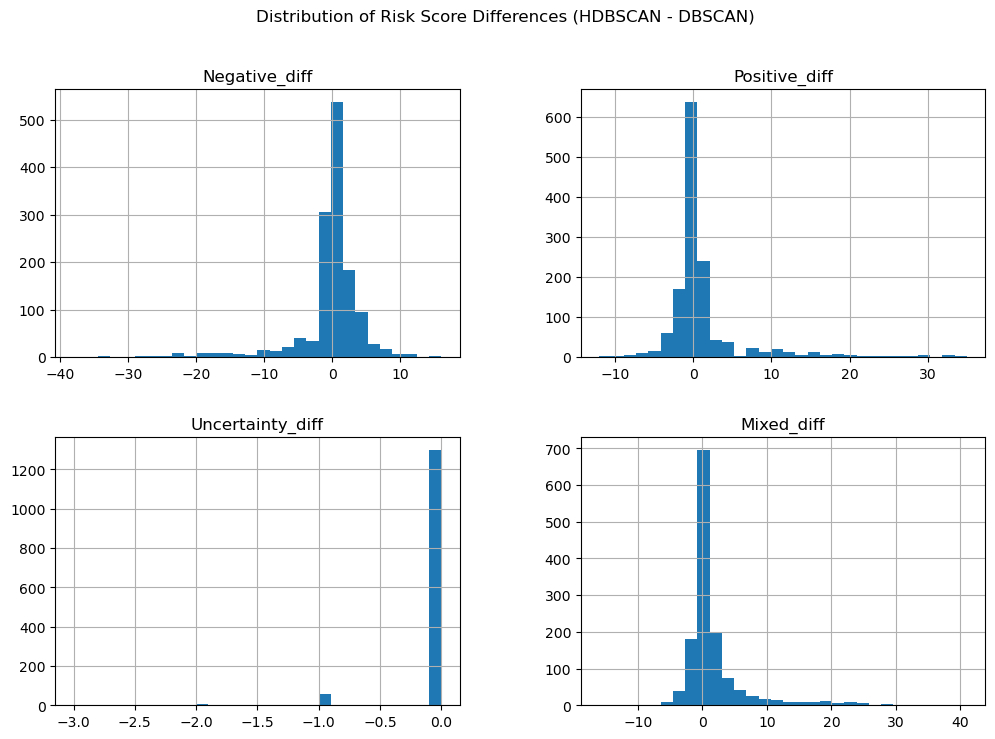

In [16]:
import matplotlib.pyplot as plt

full_comparison[['Negative_diff', 'Positive_diff', 'Uncertainty_diff', 'Mixed_diff']].hist(bins=30, figsize=(12, 8))
plt.suptitle("Distribution of Risk Score Differences (HDBSCAN - DBSCAN)")
plt.show()


**Negative diff**
- there is a long tail < 0 so that means that in some clusters, DBSCAN labelled more articles as negative across more tickers than HDBSCAN
    - could be because DBSCAN labelled broader and noisier clusters
- because there is a large bar >0 we can say that HDBSCAN labelled more articles as negative but by a thin margin since the large bar is a little above 0 
    - could be that HDBSCAN was more precise and made tighter clusters (lack of tail towards right end)

**Uncertainty diff**
- Tall bar at slightly left of 0 means that most tickers had nearly identical Uncertainty scores from both DBSCAN and HDBSCAN. 
    - they both agree on how much Uncertainty sentiment there is 
- There is a small tail towards the left meaning that DBSCAN had more Uncertainty tags than HDBSCAN
    - why? 
        - could be that DBSCAN made larger Uncertainty clusters 
        - could be that HDBSCAN didn't think those articles were strong enough to form an uncertain cluster

**Positive diff**
- Tallest bar is dancing around 0, favoring < 0. Means that both algorithms labelled the similar amount of tickers as positive, with DBSCAN having more tickers labeled as positive 
    - could be that DBSCAN is tagging more liberally or that it created large clusters that it labelled as positive
- There is a long right tail which means that HDBSCAN made more distinct clusters that had more strongly positive articles 
    - could be sentiment clusters that DBSCAN labelled as noise or maybe it was added with a larger cluster that didn't have a positive sentiment, so it got diluted.

**Mixed diff**
- Tallest bar centered near 0, meaning most tickers had similar levels of mixed sentiment tagging by both models. 
    - Mixed was the fallback so these would be clusters that didn't lean towards any predefined category 
- shape is ALMOST symmetric, with a right tail. so for the most part both algorithms agreed on what articles were ambigious in what tickers. 
    - the right tail means HDBSCAN was more liberal with this classification. 
        - could be that it was more accurate in clustering noisy articles
        - Could be that DBSCAN diluted some of these articles in Postive, Negative, or Uncertain clusters

# TOP 10 differences in tickers

In [17]:
full_comparison['total_diff'] = diff_df.abs().sum(axis=1)
top_diff_tickers = full_comparison.sort_values('total_diff', ascending=False).head(10)
top_diff_tickers

,Negative_hdb,Positive_hdb,Uncertainty_hdb,Mixed Sentiment_hdb,Negative_db,Positive_db,Uncertainty_db,Mixed Sentiment_db,Negative_diff,Positive_diff,Uncertainty_diff,Mixed_diff,total_diff
ticker,,,,,,,,,,,,,
CRM,1099,1098,10,41,1137,1108,10,0,-38,-10,0,41,89
AMGN,660,660,0,39,690,663,0,2,-30,-3,0,37,70
MU,1309,1307,14,35,1342,1309,14,0,-33,-2,0,35,70
AMZN,5777,5774,13,39,5804,5786,13,10,-27,-12,0,29,68
GOOGL,5815,5812,10,40,5849,5812,10,6,-34,0,0,34,68
BA,3780,3780,12,9,3764,3748,12,25,16,32,0,-16,64
SNOW,741,741,10,30,768,745,10,0,-27,-4,0,30,61
CAT,643,642,1,32,671,643,1,0,-28,-1,0,32,61
FCX,346,346,2,35,375,348,2,6,-29,-2,0,29,60


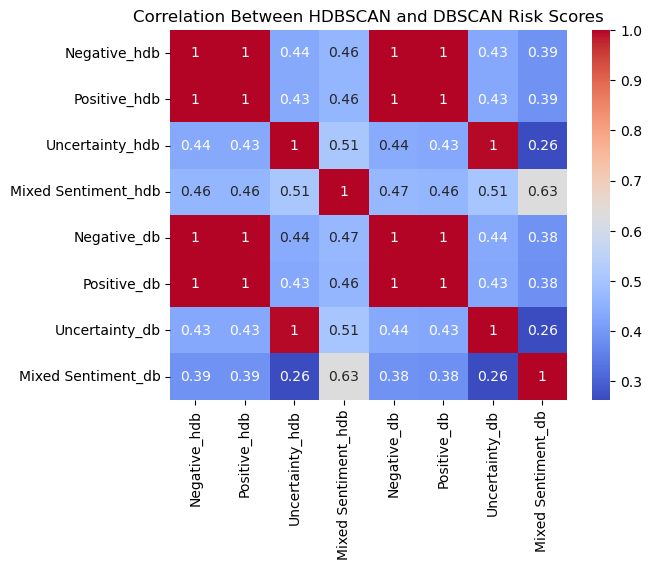

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

combined = pd.concat([hdbscan_grouped.add_suffix("_hdb"), dbscan_grouped.add_suffix("_db")], axis=1)
sns.heatmap(combined.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between HDBSCAN and DBSCAN Risk Scores")
plt.show()
